In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.models import resnet18
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd

### Bridge2AI dataset

In [2]:
dataset = VBAIDataset('./bids_without_sensitive_recordings')

### Dataset split
- 80% for training
- 10% for validation
- 10% for testing

In [3]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

N = len(all_identities)

train_identities = set(all_identities[:int(0.8*N)])
val_identities = set(all_identities[int(0.8*N):int(0.9*N)])
test_identities = set(all_identities[int(0.9*N):])

print('train:', len(train_identities))
print('val:', len(val_identities))
print('test:', len(test_identities))

train: 142
val: 18
test: 18


### Create PyTorch dataset of prolonged vowel audios with age and airway stenosis labels

In [4]:
qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].to_numpy().astype(str)
person_session_pairs = np.unique(person_session_pairs, axis=0).tolist()

print('Found {} person/session pairs'.format(len(person_session_pairs)))

Found 204 person/session pairs


In [5]:
class MySpecgramDataset(torch.utils.data.Dataset):
	def __init__(self, identities, dataset, person_session_pairs, segment_size=3):
		self.segment_size = segment_size
		
		# get age and airway stenosis classification for all subjects
		participant_df = dataset.load_and_pivot_questionnaire('participant')
		age_df = participant_df[['record_id', 'age']].to_numpy()
		airway_stenosis_df = participant_df[['record_id', 'airway_stenosis']].to_numpy()
        
		age_dict = {}
		for person_id, age in age_df:
			age_dict[str(person_id)] = float(age)
		airway_stenosis_dict = {}
		for person_id, airway_stenosis in airway_stenosis_df:
			airway_stenosis_dict[str(person_id)] = float(airway_stenosis)

		# get all prolonged vowel audios
		self.audio_files = []
		self.age = []
		self.airway_stenosis = []
        
		for person_id, session_id in person_session_pairs:
			if person_id not in identities:
				continue
			vowel_audios = [str(x) for x in dataset.find_audio(person_id, session_id) if str(x).endswith('-Prolonged-vowel.wav')]
			self.audio_files += vowel_audios
			self.age += [age_dict[person_id]]*len(vowel_audios)
			self.airway_stenosis += [airway_stenosis_dict[person_id]]*len(vowel_audios)

	def __len__(self):
		return len(self.audio_files)

	def __getitem__(self, idx):
		audio = Audio.from_file(self.audio_files[idx])
		audio = audio.to_16khz()
		# get middle K seconds if audio is too long, pad with zeros if it is too short
		if audio.signal.size(0) > self.segment_size*16000:
			d = (audio.signal.size(0)-self.segment_size*16000)//2
			audio.signal = audio.signal[d:d+self.segment_size*16000]
		else:
			audio.signal = torch.nn.functional.pad(audio.signal, (0,self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)

		win_length = 30
		hop_length = 10
		nfft = 512
		features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
		features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10)))

		return {'signal': features_specgram, 'age': self.age[idx], 'airway_stenosis': self.airway_stenosis[idx]}

tensor([27., 51., 70., 56., 74., 74., 25., 68.], dtype=torch.float64) tensor([0., 1., 1., 1., 0., 1., 0., 0.], dtype=torch.float64)


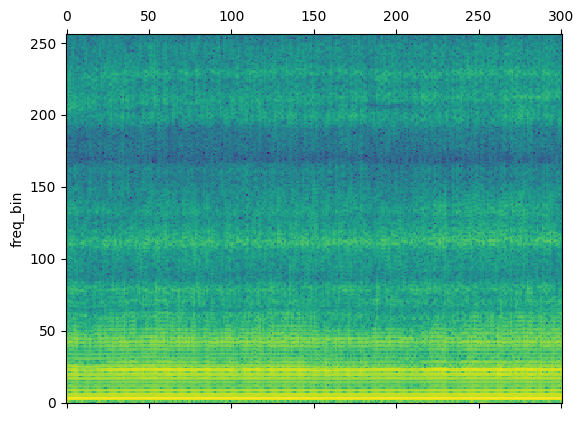

In [6]:
train_dataset = MySpecgramDataset(train_identities, dataset, person_session_pairs)
val_dataset = MySpecgramDataset(val_identities, dataset, person_session_pairs)
test_dataset = MySpecgramDataset(test_identities, dataset, person_session_pairs)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

for batch in train_dataloader:
	print(batch['age'], batch['airway_stenosis'])
	plot_spectrogram(batch['signal'][0].T)
	break

### Transformer Model

In [36]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(torch.nn.Module):
    def __init__(self, ntoken, nout, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = torch.nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = torch.nn.Linear(ntoken, ninp)
        self.ninp = ninp
        self.decoder = torch.nn.Linear(ninp, nout)

    def forward(self, src):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

In [49]:
transformer = TransformerModel(257, 1, 256, 4, 512, 2, 0.1)
_ = summary(transformer, (301, 257))

Layer (type:depth-idx)                        Output Shape              Param #
├─Linear: 1-1                                 [-1, 301, 256]            66,048
├─PositionalEncoding: 1-2                     [-1, 301, 256]            --
|    └─Dropout: 2-1                           [-1, 301, 256]            --
├─TransformerEncoder: 1-3                     [-1, 301, 256]            --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderLayer: 3-1      [-1, 301, 256]            527,104
|    |    └─TransformerEncoderLayer: 3-2      [-1, 301, 256]            527,104
├─Linear: 1-4                                 [-1, 301, 1]              257
Total params: 1,120,513
Trainable params: 1,120,513
Non-trainable params: 0
Total mult-adds (M): 3.21
Input size (MB): 0.30
Forward/backward pass size (MB): 6.47
Params size (MB): 4.27
Estimated Total Size (MB): 11.04


### Training

In [50]:
def eval(model, dataloader):
	model.eval()
	acc = 0
	for batch in dataloader:
		with torch.no_grad():
			outputs = torch.mean(torch.nn.functional.sigmoid(model(batch['signal'])),dim=1).squeeze(1)
		for i in range(len(batch['signal'])):
			if outputs[i].item() > 0.5:
				acc += batch['airway_stenosis'][i]
			else:
				acc += 1.0-batch['airway_stenosis'][i]
	return acc/len(dataloader.dataset)	

num_epochs = 100
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
	transformer.train()
	
	closs = []
	for batch in train_dataloader:
		optimizer.zero_grad()
		outputs = torch.mean(torch.nn.functional.sigmoid(transformer(batch['signal'])),dim=1).squeeze(1)
		loss = torch.nn.functional.binary_cross_entropy(outputs, batch['airway_stenosis'].float())
		closs += [loss.item()]*len(batch['signal'])
		loss.backward()
		optimizer.step()

	val_acc = eval(transformer, val_dataloader)
	print('Epoch:{} TrainLoss:{:.4f} TrainACC:{:.4f} ValACC:{:.4f}'.format(epoch+1, sum(closs)/len(closs), eval(transformer, train_dataloader), val_acc))

	if val_acc >= best_val_acc:
		best_val_acc = val_acc
		torch.save(transformer.state_dict(), './my_transformer_model.pth')
		print('Saved!')

Epoch:1 TrainLoss:0.7599 TrainACC:0.3517 ValACC:0.4211
Saved!
Epoch:2 TrainLoss:0.6964 TrainACC:0.6828 ValACC:0.5789
Saved!
Epoch:3 TrainLoss:0.6187 TrainACC:0.6828 ValACC:0.5789
Saved!
Epoch:4 TrainLoss:0.6341 TrainACC:0.6966 ValACC:0.6842
Saved!
Epoch:5 TrainLoss:0.6141 TrainACC:0.6828 ValACC:0.5789
Epoch:6 TrainLoss:0.6026 TrainACC:0.6897 ValACC:0.5789
Epoch:7 TrainLoss:0.5969 TrainACC:0.7172 ValACC:0.6842
Saved!
Epoch:8 TrainLoss:0.5693 TrainACC:0.6897 ValACC:0.5789
Epoch:9 TrainLoss:0.5651 TrainACC:0.6966 ValACC:0.4737
Epoch:10 TrainLoss:0.6405 TrainACC:0.7586 ValACC:0.6316
Epoch:11 TrainLoss:0.6421 TrainACC:0.6966 ValACC:0.5789
Epoch:12 TrainLoss:0.5818 TrainACC:0.7103 ValACC:0.5789
Epoch:13 TrainLoss:0.5378 TrainACC:0.7586 ValACC:0.4737
Epoch:14 TrainLoss:0.5363 TrainACC:0.7586 ValACC:0.4737
Epoch:15 TrainLoss:0.5038 TrainACC:0.7241 ValACC:0.5789
Epoch:16 TrainLoss:0.5168 TrainACC:0.8000 ValACC:0.4737
Epoch:17 TrainLoss:0.5166 TrainACC:0.7172 ValACC:0.5263
Epoch:18 TrainLoss:0.5

### Testing

In [51]:
transformer.load_state_dict(torch.load('./my_transformer_model.pth'))
test_acc = eval(transformer, test_dataloader)
print('TestACC:{:.4f}'.format(test_acc))

TestACC:0.5625


In [52]:
transformer.eval()
acc = [0, 0]
total = [0, 0]
for batch in test_dataloader:
	with torch.no_grad():
		outputs = torch.mean(torch.nn.functional.sigmoid(transformer(batch['signal'])),dim=1).squeeze(1)
	for i in range(len(batch['signal'])):
		total[int(batch['airway_stenosis'][i])] += 1
		if outputs[i].item() > 0.5:
			acc[int(batch['airway_stenosis'][i])] += batch['airway_stenosis'][i]
		else:
			acc[int(batch['airway_stenosis'][i])] += 1.0-batch['airway_stenosis'][i]

print('Class #0 ({}) ACC:{:.4f} Class #1 ({}) ACC:{:.4f}'.format(total[0], acc[0]/total[0], total[1], acc[1]/total[1]))

Class #0 (9) ACC:0.7778 Class #1 (7) ACC:0.2857
